# 🔬 TeleScent Model Comparison - Finding the Best Algorithm

## Goal: Find the best ML algorithm for scent detection

Testing multiple algorithms:
- Random Forest (current baseline)
- Gradient Boosting (XGBoost, LightGBM)
- Support Vector Machine (SVM)
- K-Nearest Neighbors (KNN)
- Multi-Layer Perceptron (Neural Network)
- Naive Bayes

Focus: **Real-world generalization**, not just test accuracy!

In [1]:
# Import libraries
import os
import json
import time
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Multiple algorithms to test
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [2]:
# Configuration
DATA_FILE = 'NATURAL_ML_Data_with_no_scent.xlsx'
MODEL_DIR = Path('model')
MODEL_DIR.mkdir(exist_ok=True)

TEST_SIZE = 0.2
RANDOM_STATE = 42
CV_FOLDS = 5

print(f"📁 Data file: {DATA_FILE}")
print(f"💾 Model directory: {MODEL_DIR}")
print(f"🔢 Cross-validation: {CV_FOLDS} folds")
print(f"📊 Test size: {TEST_SIZE*100}%")

📁 Data file: NATURAL_ML_Data_with_no_scent.xlsx
💾 Model directory: model
🔢 Cross-validation: 5 folds
📊 Test size: 20.0%


In [3]:
# Load dataset
print(f"📖 Loading dataset from {DATA_FILE}...")
df = pd.read_excel(DATA_FILE)

print(f"✅ Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\n🎯 Classes in dataset:")
print(df['scent_name'].value_counts())

# Show sample
display(df.head())

📖 Loading dataset from NATURAL_ML_Data_with_no_scent.xlsx...
✅ Dataset loaded: 7920 rows × 17 columns

🎯 Classes in dataset:
scent_name
no_scent       2000
cinnamon       1480
gingerbread    1480
norange        1480
vanilla        1480
Name: count, dtype: int64


,sample_id,trial_number,scent_id,scent_name,phase,time_s,timestamp_ms,temp_C,humidity_pct,pressure_kPa,gas_bme,srawVoc,srawNox,NO2,ethanol,VOC_multichannel,COandH2
0,61,1,13,no_scent,baseline,0.000,0,23.31,41.70,101.47,122.62,31317,15073,222,242,286,870
1,61,1,13,no_scent,baseline,1.215,1215,23.31,41.69,101.47,123.43,31241,15081,222,241,287,869
2,61,1,13,no_scent,baseline,2.430,2430,23.31,41.71,101.47,122.00,31247,15081,221,242,287,869
3,61,1,13,no_scent,baseline,3.645,3645,23.31,41.69,101.47,122.62,31248,15082,222,241,286,870
4,61,1,13,no_scent,baseline,4.860,4860,23.31,41.70,101.47,122.71,31273,15072,221,241,287,870


In [4]:
# Feature Engineering (same as current model)
print("🧪 Feature Engineering...")

# Raw features
feature_cols = ['srawVoc', 'srawNox', 'NO2', 'ethanol', 'VOC_multichannel', 'COandH2']
X = df[feature_cols].copy()

# 1. VOC RATIOS
X['voc_ratio'] = X['VOC_multichannel'] / (X['srawVoc'] + 1)
X['ethanol_voc_ratio'] = X['ethanol'] / (X['VOC_multichannel'] + 1)
X['voc_balance'] = (X['VOC_multichannel'] - X['ethanol']) / (X['VOC_multichannel'] + X['ethanol'] + 1)

# 2. NOx INDICATORS
X['nox_intensity'] = X['NO2'] / (X['srawNox'] + 1)
X['nox_balance'] = (X['NO2'] - X['srawNox'] / 100) / (X['NO2'] + X['srawNox'] / 100 + 1)

# 3. GAS INTERACTIONS
X['voc_no2_interaction'] = X['VOC_multichannel'] * X['NO2'] / 1000
X['ethanol_no2_ratio'] = X['ethanol'] / (X['NO2'] + 1)
X['co_voc_ratio'] = X['COandH2'] / (X['VOC_multichannel'] + 1)

# 4. CHEMICAL COMPLEXITY
X['total_voc_intensity'] = X['VOC_multichannel'] + X['ethanol'] + X['srawVoc'] / 100
X['chemical_diversity'] = np.std(X[['NO2', 'ethanol', 'VOC_multichannel', 'COandH2']], axis=1)
X['gas_dominance'] = X[['NO2', 'ethanol', 'VOC_multichannel', 'COandH2']].max(axis=1) / (X[['NO2', 'ethanol', 'VOC_multichannel', 'COandH2']].mean(axis=1) + 1)

# 5. NORMALIZED SENSORS
for col in ['srawVoc', 'srawNox']:
    col_mean = X[col].mean()
    col_std = X[col].std()
    X[f'{col}_normalized'] = (X[col] - col_mean) / (col_std + 1)

# Replace inf with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

print(f"✅ Engineered features: {X.shape[1]} total features")
print(f"   Features: {list(X.columns)}")

🧪 Feature Engineering...
✅ Engineered features: 19 total features
   Features: ['srawVoc', 'srawNox', 'NO2', 'ethanol', 'VOC_multichannel', 'COandH2', 'voc_ratio', 'ethanol_voc_ratio', 'voc_balance', 'nox_intensity', 'nox_balance', 'voc_no2_interaction', 'ethanol_no2_ratio', 'co_voc_ratio', 'total_voc_intensity', 'chemical_diversity', 'gas_dominance', 'srawVoc_normalized', 'srawNox_normalized']


In [5]:
# Prepare data
y = df['scent_name'].copy()

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"🏷️  Label Encoding:")
for i, label in enumerate(label_encoder.classes_):
    count = (y == label).sum()
    print(f"  {label} → {i} ({count} samples)")

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=y_encoded
)

print(f"\n📊 Data split:")
print(f"   Training: {X_train.shape[0]} samples")
print(f"   Test: {X_test.shape[0]} samples")

🏷️  Label Encoding:
  cinnamon → 0 (1480 samples)
  gingerbread → 1 (1480 samples)
  no_scent → 2 (2000 samples)
  norange → 3 (1480 samples)
  vanilla → 4 (1480 samples)

📊 Data split:
   Training: 6336 samples
   Test: 1584 samples


## 🤖 Algorithm Comparison

We'll test each algorithm with:
1. **5-fold Cross-Validation** - More reliable than single test split
2. **Training Time** - Important for retraining
3. **Test Accuracy** - Final performance
4. **Per-Class Performance** - Check if any class is failing

In [6]:
# Define algorithms to test
algorithms = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=RANDOM_STATE
    ),
    'SVM (RBF)': SVC(
        kernel='rbf',
        C=10,
        gamma='scale',
        random_state=RANDOM_STATE
    ),
    'SVM (Linear)': SVC(
        kernel='linear',
        C=1.0,
        random_state=RANDOM_STATE
    ),
    'K-Nearest Neighbors': KNeighborsClassifier(
        n_neighbors=7,
        weights='distance',
        metric='euclidean'
    ),
    'Neural Network': MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        max_iter=500,
        random_state=RANDOM_STATE,
        early_stopping=True
    ),
    'Naive Bayes': GaussianNB(),
    'AdaBoost': AdaBoostClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=20,
        random_state=RANDOM_STATE
    )
}

print(f"🔬 Testing {len(algorithms)} algorithms:")
for name in algorithms.keys():
    print(f"  • {name}")

🔬 Testing 9 algorithms:
  • Random Forest
  • Gradient Boosting
  • SVM (RBF)
  • SVM (Linear)
  • K-Nearest Neighbors
  • Neural Network
  • Naive Bayes
  • AdaBoost
  • Decision Tree


In [7]:
# Test all algorithms
results = []

print("🚀 Starting algorithm comparison...")
print("=" * 80)

for name, classifier in algorithms.items():
    print(f"\n📊 Testing: {name}")
    print("-" * 80)
    
    # Create pipeline
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('classifier', classifier)
    ])
    
    # Cross-validation
    start_time = time.time()
    cv_scores = cross_val_score(
        pipeline, X_train, y_train, 
        cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
        scoring='accuracy',
        n_jobs=-1
    )
    cv_time = time.time() - start_time
    
    # Train on full training set
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Test set performance
    y_pred = pipeline.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    # Store results
    result = {
        'Algorithm': name,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Test Accuracy': test_accuracy,
        'Train Time (s)': train_time,
        'CV Time (s)': cv_time,
        'Pipeline': pipeline
    }
    results.append(result)
    
    print(f"  CV Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"  Test Accuracy: {test_accuracy:.4f}")
    print(f"  Training Time: {train_time:.2f}s")

print("\n" + "=" * 80)
print("✅ All algorithms tested!")

🚀 Starting algorithm comparison...

📊 Testing: Random Forest
--------------------------------------------------------------------------------
  CV Score: 0.9730 (±0.0044)
  Test Accuracy: 0.9722
  Training Time: 0.21s

📊 Testing: Gradient Boosting
--------------------------------------------------------------------------------
  CV Score: 0.9717 (±0.0050)
  Test Accuracy: 0.9678
  Training Time: 20.87s

📊 Testing: SVM (RBF)
--------------------------------------------------------------------------------
  CV Score: 0.9586 (±0.0049)
  Test Accuracy: 0.9609
  Training Time: 0.19s

📊 Testing: SVM (Linear)
--------------------------------------------------------------------------------
  CV Score: 0.9175 (±0.0105)
  Test Accuracy: 0.9223
  Training Time: 0.22s

📊 Testing: K-Nearest Neighbors
--------------------------------------------------------------------------------
  CV Score: 0.9665 (±0.0072)
  Test Accuracy: 0.9646
  Training Time: 0.01s

📊 Testing: Neural Network
-----------------

In [8]:
# Create results dataframe
results_df = pd.DataFrame([
    {k: v for k, v in r.items() if k != 'Pipeline'}
    for r in results
])

# Sort by CV Mean (most reliable metric)
results_df = results_df.sort_values('CV Mean', ascending=False)

print("📊 ALGORITHM COMPARISON RESULTS")
print("=" * 80)
display(results_df.style.background_gradient(subset=['CV Mean', 'Test Accuracy'], cmap='RdYlGn'))

# Highlight best
best_algo = results_df.iloc[0]
print(f"\n🏆 BEST ALGORITHM: {best_algo['Algorithm']}")
print(f"   CV Score: {best_algo['CV Mean']:.4f} (±{best_algo['CV Std']:.4f})")
print(f"   Test Accuracy: {best_algo['Test Accuracy']:.4f}")
print(f"   Training Time: {best_algo['Train Time (s)']:.2f}s")

📊 ALGORITHM COMPARISON RESULTS


,Algorithm,CV Mean,CV Std,Test Accuracy,Train Time (s),CV Time (s)
0,Random Forest,0.973011,0.004394,0.972222,0.213343,1.770066
1,Gradient Boosting,0.971749,0.005002,0.967803,20.874950,29.396863
4,K-Nearest Neighbors,0.966540,0.007228,0.964646,0.007898,0.084343
5,Neural Network,0.960543,0.004686,0.955808,2.125646,1.852439
2,SVM (RBF),0.958649,0.004884,0.960859,0.185499,1.162868
8,Decision Tree,0.952810,0.006417,0.958965,0.092039,0.145649
3,SVM (Linear),0.917455,0.010507,0.922348,0.222058,0.306342
7,AdaBoost,0.691129,0.010046,0.712121,1.329981,1.942727
6,Naive Bayes,0.684184,0.018263,0.688763,0.016637,0.108211



🏆 BEST ALGORITHM: Random Forest
   CV Score: 0.9730 (±0.0044)
   Test Accuracy: 0.9722
   Training Time: 0.21s


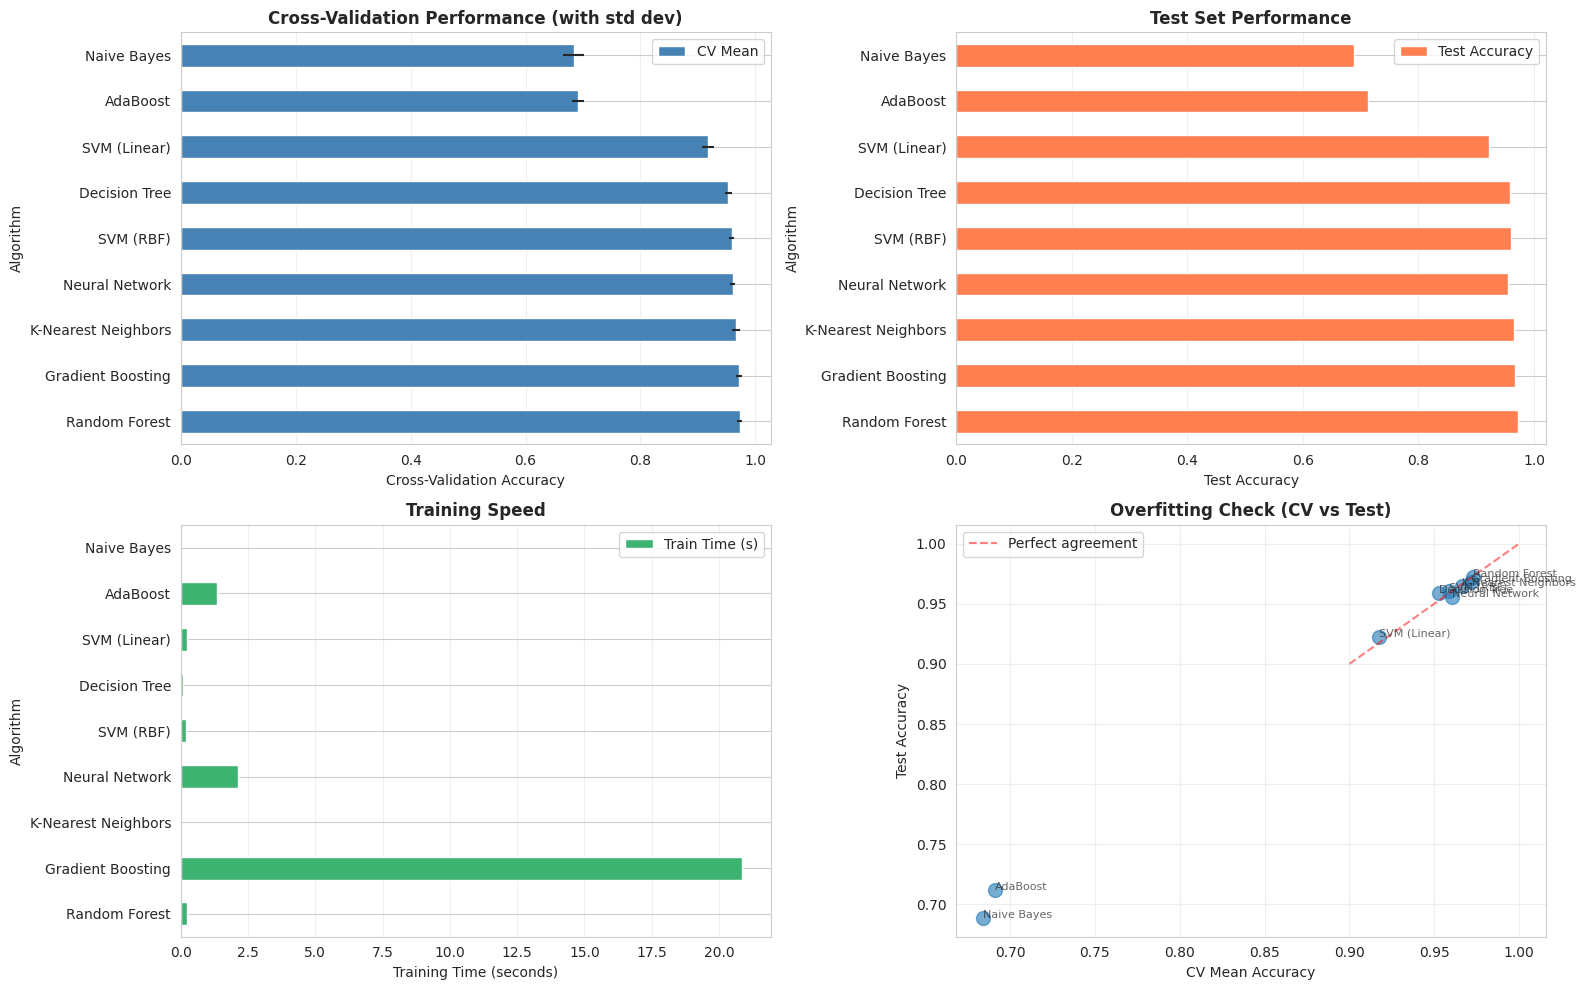

In [9]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. CV Score comparison
ax1 = axes[0, 0]
results_df.plot(x='Algorithm', y='CV Mean', kind='barh', ax=ax1, color='steelblue', xerr='CV Std')
ax1.set_xlabel('Cross-Validation Accuracy')
ax1.set_title('Cross-Validation Performance (with std dev)', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# 2. Test accuracy comparison
ax2 = axes[0, 1]
results_df.plot(x='Algorithm', y='Test Accuracy', kind='barh', ax=ax2, color='coral')
ax2.set_xlabel('Test Accuracy')
ax2.set_title('Test Set Performance', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 3. Training time
ax3 = axes[1, 0]
results_df.plot(x='Algorithm', y='Train Time (s)', kind='barh', ax=ax3, color='mediumseagreen')
ax3.set_xlabel('Training Time (seconds)')
ax3.set_title('Training Speed', fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# 4. CV vs Test (overfitting check)
ax4 = axes[1, 1]
ax4.scatter(results_df['CV Mean'], results_df['Test Accuracy'], s=100, alpha=0.6)
for idx, row in results_df.iterrows():
    ax4.annotate(row['Algorithm'], (row['CV Mean'], row['Test Accuracy']), 
                fontsize=8, alpha=0.7)
ax4.plot([0.9, 1.0], [0.9, 1.0], 'r--', alpha=0.5, label='Perfect agreement')
ax4.set_xlabel('CV Mean Accuracy')
ax4.set_ylabel('Test Accuracy')
ax4.set_title('Overfitting Check (CV vs Test)', fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

🔍 DETAILED ANALYSIS: Random Forest

📋 Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

    cinnamon      1.000     0.976     0.988       296
 gingerbread      0.989     0.953     0.971       296
    no_scent      0.914     0.985     0.948       400
     norange      1.000     0.980     0.990       296
     vanilla      0.986     0.963     0.974       296

    accuracy                          0.972      1584
   macro avg      0.978     0.971     0.974      1584
weighted avg      0.974     0.972     0.973      1584



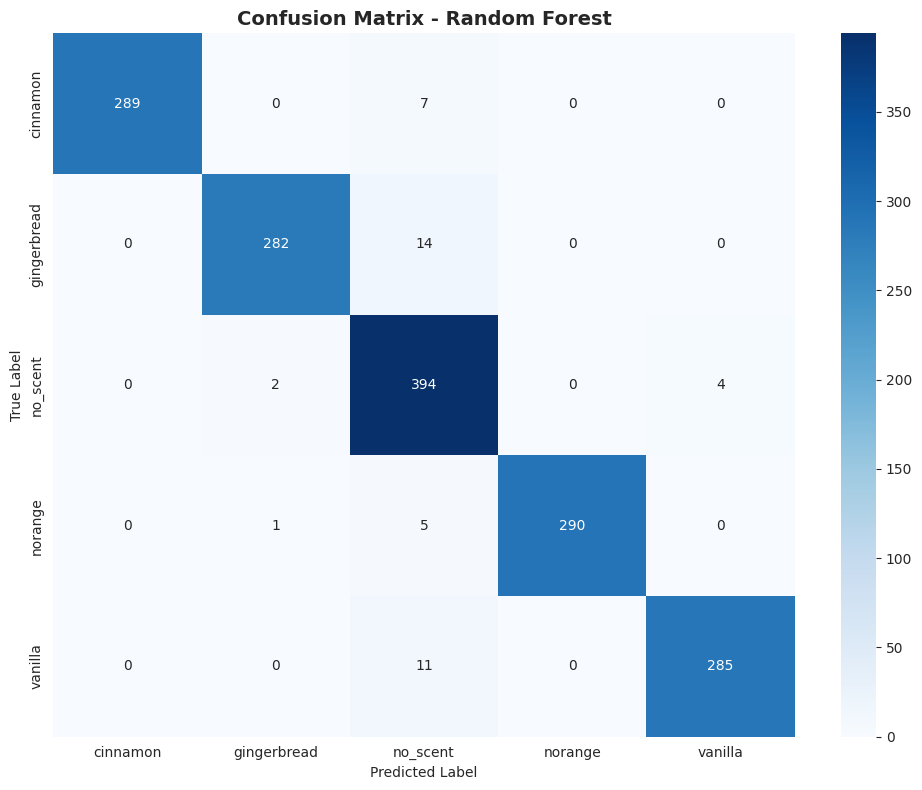


🎯 Per-Class Accuracy:
--------------------------------------------------------------------------------
  cinnamon       : 0.976 (296 samples)
  gingerbread    : 0.953 (296 samples)
  no_scent       : 0.985 (400 samples)
  norange        : 0.980 (296 samples)
  vanilla        : 0.963 (296 samples)


In [10]:
# Get best model and show detailed performance
best_result = results[results_df.index[0]]
best_pipeline = best_result['Pipeline']
best_name = best_result['Algorithm']

print(f"🔍 DETAILED ANALYSIS: {best_name}")
print("=" * 80)

# Predictions
y_pred = best_pipeline.predict(X_test)

# Classification report
print("\n📋 Classification Report:")
print("-" * 80)
print(classification_report(
    y_test, y_pred,
    target_names=label_encoder.classes_,
    digits=3
))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_name}', fontweight='bold', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\n🎯 Per-Class Accuracy:")
print("-" * 80)
for i, scent in enumerate(label_encoder.classes_):
    mask = y_test == i
    if mask.sum() > 0:
        acc = accuracy_score(y_test[mask], y_pred[mask])
        print(f"  {scent:15s}: {acc:.3f} ({mask.sum()} samples)")

## 💾 Save Best Model

In [11]:
# Save the best model
BEST_PIPELINE_PATH = MODEL_DIR / 'scent_pipeline_best.joblib'
BEST_LABEL_ENCODER_PATH = MODEL_DIR / 'label_encoder_best.joblib'

print(f"💾 Saving best model: {best_name}")
print("=" * 80)

# Save pipeline and encoder
joblib.dump(best_pipeline, BEST_PIPELINE_PATH)
joblib.dump(label_encoder, BEST_LABEL_ENCODER_PATH)

print(f"✅ Pipeline saved to: {BEST_PIPELINE_PATH}")
print(f"✅ Label encoder saved to: {BEST_LABEL_ENCODER_PATH}")

# Save metadata
metadata = {
    'best_algorithm': best_name,
    'cv_mean_accuracy': float(best_result['CV Mean']),
    'cv_std_accuracy': float(best_result['CV Std']),
    'test_accuracy': float(best_result['Test Accuracy']),
    'training_time_seconds': float(best_result['Train Time (s)']),
    'classes': label_encoder.classes_.tolist(),
    'n_features': X_train.shape[1],
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'dataset': DATA_FILE,
    'comparison_results': results_df.to_dict('records')
}

metadata_path = MODEL_DIR / 'best_model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✅ Metadata saved to: {metadata_path}")
print(f"\n🎉 Best model saved successfully!")

💾 Saving best model: Random Forest
✅ Pipeline saved to: model/scent_pipeline_best.joblib
✅ Label encoder saved to: model/label_encoder_best.joblib
✅ Metadata saved to: model/best_model_metadata.json

🎉 Best model saved successfully!


## 🧪 Test Best Model with Real Samples

In [12]:
# Test with real samples from each class
print("🧪 Testing Best Model with Real Samples")
print("=" * 80)

test_scents = label_encoder.classes_

for scent in test_scents:
    # Get a sample from the test set
    scent_idx = label_encoder.transform([scent])[0]
    test_indices = np.where(y_test == scent_idx)[0]
    
    if len(test_indices) > 0:
        # Get middle sample
        sample_idx = test_indices[len(test_indices) // 2]
        sample_features = X_test.iloc[[sample_idx]]
        
        # Predict
        pred_idx = best_pipeline.predict(sample_features)[0]
        pred_proba = best_pipeline.predict_proba(sample_features)[0]
        pred_scent = label_encoder.inverse_transform([pred_idx])[0]
        
        # Show result
        correct = pred_scent == scent
        emoji = "✅" if correct else "❌"
        
        print(f"\n{emoji} Expected: {scent:15s} → Predicted: {pred_scent:15s} ({pred_proba[pred_idx]:.1%})")
        
        # Show top 3 predictions
        top3_idx = np.argsort(pred_proba)[::-1][:3]
        print(f"   Top 3: ", end="")
        for idx in top3_idx:
            print(f"{label_encoder.classes_[idx]}({pred_proba[idx]:.1%}) ", end="")
        print()

print("\n" + "=" * 80)
print("✅ Testing complete!")

🧪 Testing Best Model with Real Samples

✅ Expected: cinnamon        → Predicted: cinnamon        (100.0%)
   Top 3: cinnamon(100.0%) vanilla(0.0%) norange(0.0%) 

✅ Expected: gingerbread     → Predicted: gingerbread     (100.0%)
   Top 3: gingerbread(100.0%) vanilla(0.0%) norange(0.0%) 

✅ Expected: no_scent        → Predicted: no_scent        (100.0%)
   Top 3: no_scent(100.0%) vanilla(0.0%) norange(0.0%) 

✅ Expected: norange         → Predicted: norange         (99.0%)
   Top 3: norange(99.0%) cinnamon(1.0%) vanilla(0.0%) 

✅ Expected: vanilla         → Predicted: vanilla         (100.0%)
   Top 3: vanilla(100.0%) norange(0.0%) no_scent(0.0%) 

✅ Testing complete!


## 📊 Summary & Recommendations

In [14]:
print("📊 FINAL SUMMARY")
print("=" * 80)

print(f"\n🏆 Best Algorithm: {best_name}")
print(f"   • Cross-Validation: {best_result['CV Mean']:.4f} (±{best_result['CV Std']:.4f})")
print(f"   • Test Accuracy: {best_result['Test Accuracy']:.4f}")
print(f"   • Training Time: {best_result['Train Time (s)']:.2f}s")

print(f"\n📈 Top 3 Algorithms:")
for i, row in results_df.head(3).iterrows():
    print(f"   {i+1}. {row['Algorithm']:20s} - CV: {row['CV Mean']:.4f}, Test: {row['Test Accuracy']:.4f}")

print(f"\n💡 Recommendations:")
if best_result['CV Mean'] > 0.95:
    print("   ✅ Model shows excellent performance!")
    print("   → If real-world performance is poor, issue is likely:")
    print("      • Sensor calibration differences")
    print("      • Environmental conditions (temp, humidity)")
    print("      • Data collection artifacts")
else:
    print("   ⚠️  Model performance could be improved")
    print("   → Consider:")
    print("      • Collecting more training data")
    print("      • Trying ensemble methods")
    print("      • Hyperparameter tuning")

print(f"\n🔄 Next Steps:")
print(f"   1. Copy best model to production:")
print(f"      cp {BEST_PIPELINE_PATH} {MODEL_DIR}/scent_pipeline.joblib")
print(f"      cp {BEST_LABEL_ENCODER_PATH} {MODEL_DIR}/label_encoder.joblib")
print(f"   2. Restart backend server")
print(f"   3. Test with real sensor data")
print(f"   4. Monitor per-class accuracy")

print("\n" + "=" * 80)
print("✅ Model comparison complete!")

📊 FINAL SUMMARY

🏆 Best Algorithm: Random Forest
   • Cross-Validation: 0.9730 (±0.0044)
   • Test Accuracy: 0.9722
   • Training Time: 0.21s

📈 Top 3 Algorithms:
   1. Random Forest        - CV: 0.9730, Test: 0.9722
   2. Gradient Boosting    - CV: 0.9717, Test: 0.9678
   5. K-Nearest Neighbors  - CV: 0.9665, Test: 0.9646

💡 Recommendations:
   ✅ Model shows excellent performance!
   → If real-world performance is poor, issue is likely:
      • Sensor calibration differences
      • Environmental conditions (temp, humidity)
      • Data collection artifacts

🔄 Next Steps:
   1. Copy best model to production:
      cp model/scent_pipeline_best.joblib model/scent_pipeline.joblib
      cp model/label_encoder_best.joblib model/label_encoder.joblib
   2. Restart backend server
   3. Test with real sensor data
   4. Monitor per-class accuracy

✅ Model comparison complete!
